In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix,  precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split , KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from scipy.stats import f_oneway
from xgboost import XGBClassifier

In [2]:
# Leer el archivo Excel
file_path = r"C:\Users\Federico\Downloads\dabe de datos.xlsx"
df = pd.read_excel(file_path)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.0990 - loss: 4.5073 - val_accuracy: 0.3855 - val_loss: 3.0064
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3596 - loss: 2.9113 - val_accuracy: 0.5542 - val_loss: 2.1589
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4713 - loss: 2.2913 - val_accuracy: 0.5981 - val_loss: 1.8793
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5408 - loss: 2.0169 - val_accuracy: 0.6320 - val_loss: 1.7532
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6004 - loss: 1.8571 - val_accuracy: 0.6519 - val_loss: 1.6784
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6297 - loss: 1.7488 - val_accuracy: 0.6838 - val_loss: 1.6226
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6617 - loss: 1.6757 - val_accuracy: 0.6883 - val_loss: 1.5828
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6834 - loss: 1.6057 - val_accu

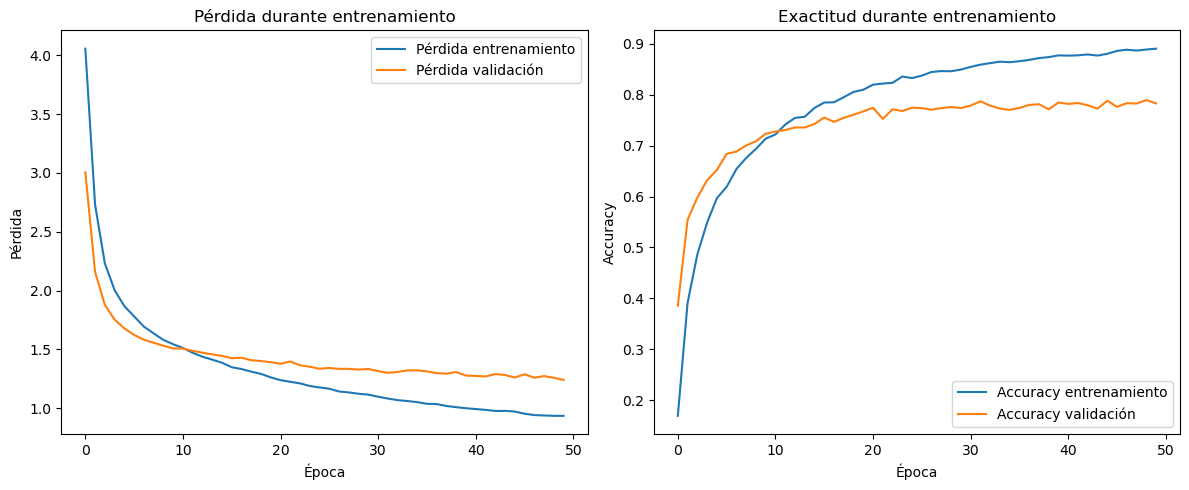

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


file_path = r"C:\Users\Federico\Downloads\dabe de datos.xlsx"
df = pd.read_excel(file_path)
# -------------------------------
# 1. Filtrar clases con frecuencia >= 70
# -------------------------------
frequencies = df['GRD -Código'].value_counts()
valid_classes = frequencies[frequencies >= 70].index
df = df[df['GRD -Código'].isin(valid_classes)].copy()

# -------------------------------
# 2. Prefiltrado y limpieza de variables de interés
# -------------------------------
variables_interes = [
    'Situacion al alta','Edad','Grupo Edad','Días estancia','Dx principal de egreso ','Cuidados intensivos',
    'Días de Unidad Cuidado Intensivo','Tipo de ingreso','Dx principal de egreso .1',
    'Código causa externa','Proc1','Proc2','Proc3','Dxr 1','Dxr 2','Dx Ppal 3 Caracteres',
    'Infección Quirurgica','Tipo servicio','Infecciones','Dx de ingreso','ServicioAlta',
    'Proc4','Sexo','Dxr 3','Causa externa','Aseguradora -Código-',
    'Aseguradora -Descripción-','Dxr 4','Causa Basica de muerte','Dxr 5','Codigo de ciudad',
    'Proc5','Dxr-6','Proc6','Dxr 7','Proc7','Dxr 8','Dxr 9','Proc8','Proc9','Proc16','Proc28'
]

# Subconjunto de datos
df_selected = df[variables_interes].copy()

# Limpieza de texto: pasar todo a mayúsculas para unificar categorías
df_selected = df_selected.apply(lambda col: col.apply(lambda x: x.upper() if isinstance(x, str) else x)
                                if col.dtype == 'object' else col)

# Normalizar nombres de categorías específicas
df_selected['Tipo de ingreso'] = df_selected['Tipo de ingreso'].str.replace('URGENCIAS', 'URGENCIA', regex=False)
df_selected['Tipo servicio'] = df_selected['Tipo servicio'].replace({
    'ATENCIÓN PRIORITARIA': 'URGENCIA ADULTOS',
    'URGENCIA - ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA ADULTO': 'URGENCIA ADULTOS',
    'URGENCIA ADULTOS.': 'URGENCIA ADULTOS',
    'U. ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA PEDIATRICAS': 'URGENCIA PEDÍATRICAS',
    'N0 APLICA': 'NO APLICA',
    'CIRUGIA': 'CIRUGÍA'
})

df_selected['Situacion al alta'] = df_selected['Situacion al alta'].replace({
    'MUERTO': 'FALLECIDO',
    'ALTA MEDICA': 'ALTA MÉDICA',
})

# -------------------------------
# 3. Separar variable objetivo y características
# -------------------------------
y = df['GRD -Código']
X = df_selected.copy()


# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Pipelines de preprocesamiento
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Aplicar transformación
X_processed = preprocessor.fit_transform(X)

# Codificar la variable objetivo
y_encoded, y_categories = pd.factorize(y)
y_categorical = to_categorical(y_encoded)

# Dividir en entrenamiento, validación y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=np.argmax(y_train_full, axis=1)
)

# Construcción del modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación final
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\n Accuracy final en test: {accuracy:.4f}')

# 14. Graficar historia del entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.title('Exactitud durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
# mostrar cuantos de las clases
class_counts = df['GRD -Código'].value_counts()
print(class_counts)
print(f'Número de clases: {len(class_counts)}')

GRD -Código
44173     732
114122    691
54123     631
44163     578
114123    433
         ... 
64102      72
124112     70
184131     70
14243      70
54133      70
Name: count, Length: 117, dtype: int64
Número de clases: 117


Se construyó un modelo de clasificación multiclase mediante una red neuronal secuencial, orientado a predecir el código GRD a partir de variables clínicas, demográficas y administrativas. Para asegurar una representación mínima por clase, se filtraron aquellas con menos de 70 registros, quedando un total de 117 clases. Aun así, la distribución de las clases sigue siendo desigual: algunas como la 44173 alcanzan hasta 732 registros, mientras que otras apenas superan el umbral mínimo, lo que implica un desequilibrio residual que puede afectar el rendimiento por clase.

El preprocesamiento de las variables incluyó imputación (media para numéricas, moda para categóricas), escalamiento y codificación one-hot. La variable objetivo fue transformada con to_categorical para entrenamiento con categorical_crossentropy.

El modelo consistió en dos capas densas con activación ReLU, regularización L2 y Dropout, lo que favoreció la generalización. Se utilizó EarlyStopping para evitar sobreentrenamiento.

El desempeño alcanzado fue de 79.1% de precisión en el conjunto de prueba, con una pérdida de 1.3043, lo que indica buenas predicciones globales, pero con niveles de confianza mejorables.

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1069 - loss: 4.1641 - val_accuracy: 0.4430 - val_loss: 2.6345
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4173 - loss: 2.5258 - val_accuracy: 0.6044 - val_loss: 1.7620
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5577 - loss: 1.8672 - val_accuracy: 0.6579 - val_loss: 1.5323
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6152 - loss: 1.6399 - val_accuracy: 0.6809 - val_loss: 1.4301
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6656 - loss: 1.5149 - val_accuracy: 0.7048 - val_loss: 1.3677
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6890 - loss: 1.4137 - val_accuracy: 0.7250 - val_loss: 1.3286
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7257 - loss: 1.3497 - val_accuracy: 0.7435 - val_loss: 1.2934
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7458 - loss: 1.2969 - val_accu

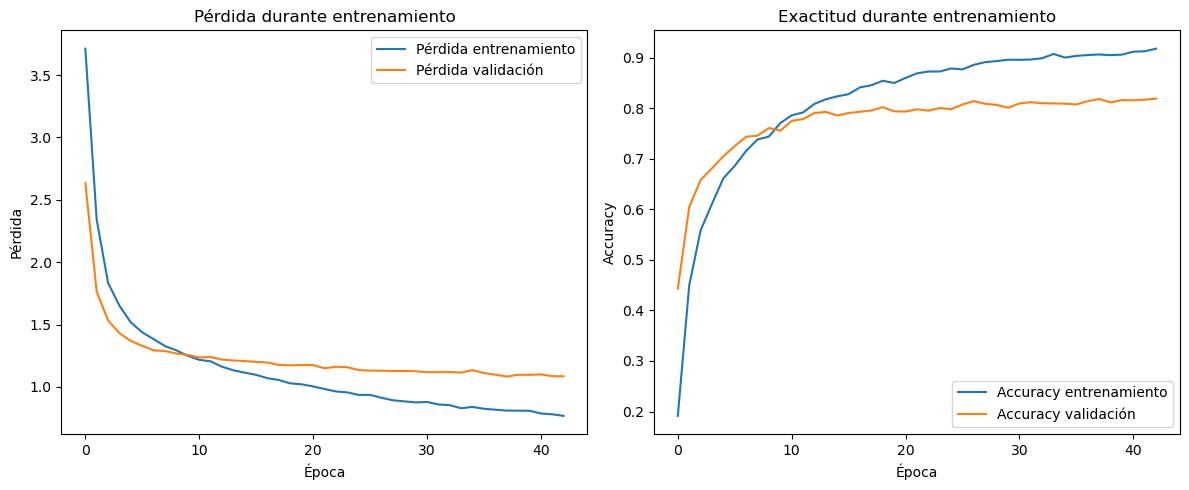

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


file_path = r"C:\Users\Federico\Downloads\dabe de datos.xlsx"
df = pd.read_excel(file_path)
# -------------------------------
# 1. Filtrar clases con frecuencia >= 100
# -------------------------------
frequencies = df['GRD -Código'].value_counts()
valid_classes = frequencies[frequencies >= 100].index
df = df[df['GRD -Código'].isin(valid_classes)].copy()

# -------------------------------
# 2. Prefiltrado y limpieza de variables de interés
# -------------------------------
variables_interes = [
    'Edad', 'Grupo Edad', 'Días estancia', 'Dx principal de egreso ', 'Cuidados intensivos',
    'Días de Unidad Cuidado Intensivo', 'Tipo de ingreso', 'Dx principal de egreso .1',
    'Código causa externa', 'Proc1', 'Proc2', 'Proc3', 'Dxr 1', 'Dxr 2', 'Dx Ppal 3 Caracteres',
    'Infección Quirurgica', 'Tipo servicio', 'Infecciones', 'Dx de ingreso', 'ServicioAlta',
    'Proc4', 'Sexo', 'Dxr 3', 'Causa externa', 'Aseguradora -Código-', 'Proc5',
    'Aseguradora -Descripción-', 'Dxr 4', 'Causa Basica de muerte', 'Dxr 5', 'Codigo de ciudad',
    'Proc6', 'Dxr-6', 'Proc7', 'Dxr 7', 'Proc8', 'Proc28', 'Dxr 8', 'Dxr 9', 'Proc9', 'Proc16',
    'Situacion al alta'
]

# Subconjunto de datos
df_selected = df[variables_interes].copy()

# Limpieza de texto: pasar todo a mayúsculas para unificar categorías
df_selected = df_selected.apply(lambda col: col.apply(lambda x: x.upper() if isinstance(x, str) else x)
                                if col.dtype == 'object' else col)

# Normalizar nombres de categorías específicas
df_selected['Tipo de ingreso'] = df_selected['Tipo de ingreso'].str.replace('URGENCIAS', 'URGENCIA', regex=False)
df_selected['Tipo servicio'] = df_selected['Tipo servicio'].replace({
    'ATENCIÓN PRIORITARIA': 'URGENCIA ADULTOS',
    'URGENCIA - ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA ADULTO': 'URGENCIA ADULTOS',
    'URGENCIA ADULTOS.': 'URGENCIA ADULTOS',
    'U. ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA PEDIATRICAS': 'URGENCIA PEDÍATRICAS',
    'N0 APLICA': 'NO APLICA',
    'CIRUGIA': 'CIRUGÍA'
})

df_selected['Situacion al alta'] = df_selected['Situacion al alta'].replace({
    'MUERTO': 'FALLECIDO',
    'ALTA MEDICA': 'ALTA MÉDICA',
})

# Reasignar X con datos limpios
X = df_selected.copy()
y = df['GRD -Código']

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Pipelines de preprocesamiento
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Aplicar transformación
X_processed = preprocessor.fit_transform(X)

# Codificar la variable objetivo
y_encoded, y_categories = pd.factorize(y)
y_categorical = to_categorical(y_encoded)

# Dividir en entrenamiento, validación y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=np.argmax(y_train_full, axis=1)
)

# Construcción del modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación final
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\n Accuracy final en test: {accuracy:.4f}')

# 14. Graficar historia del entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.title('Exactitud durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# mostrar cuantos de las clases
class_counts = df['GRD -Código'].value_counts()
print(class_counts)
print(f'Número de clases: {len(class_counts)}')

GRD -Código
44173     732
114122    691
54123     631
44163     578
114123    433
         ... 
74133     105
31201     104
51202     103
14242     103
74132     100
Name: count, Length: 79, dtype: int64
Número de clases: 79


En este segundo modelo se mantuvo la misma arquitectura y metodología general, pero se aplicó un filtro más estricto a la variable objetivo, conservando únicamente los códigos GRD con 100 o más registros, lo que redujo el número total de clases de 117 a 79. Este cambio buscó mejorar la estabilidad del entrenamiento al reducir el impacto de clases poco representadas, lo que efectivamente se reflejó en un mejor desempeño del modelo.

El preprocesamiento de las variables continuó con imputación diferenciada para variables numéricas y categóricas, escalamiento y codificación one-hot. La variable objetivo fue tratada nuevamente con to_categorical para permitir la clasificación multiclase con categorical_crossentropy.

El modelo entrenado alcanzó una precisión del 82.41% en el conjunto de prueba, con una pérdida final de 1.082, superando en ambas métricas al modelo anterior. Durante el entrenamiento, la precisión en validación llegó hasta 81%, con una pérdida de validación que se redujo progresivamente, lo que indica una mejora en la capacidad del modelo para generalizar.

Esta mejora se puede atribuir en gran parte a la reducción del número de clases y al menor desequilibrio extremo entre ellas. Aunque aún existen diferencias en la frecuencia de las clases, el nuevo umbral de inclusión favorece un aprendizaje más consistente. El modelo también mostró una mayor confianza en sus predicciones (menor entropía), reflejada en la reducción sostenida de la pérdida.

En resumen, al aplicar un umbral más alto en la frecuencia mínima por clase, se logró mejorar significativamente tanto la precisión como la estabilidad del modelo, sin necesidad de alterar su arquitectura.

c:\Users\Federico\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Proc28']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1398 - loss: 3.5784 - val_accuracy: 0.6071 - val_loss: 2.0073
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5370 - loss: 1.8976 - val_accuracy: 0.6944 - val_loss: 1.2053
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6807 - loss: 1.3049 - val_accuracy: 0.7553 - val_loss: 1.0129
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7376 - loss: 1.1077 - val_accuracy: 0.7898 - val_loss: 0.9563
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7929 - loss: 0.9938 - val_accuracy: 0.8191 - val_loss: 0.9230
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8146 - loss: 0.9438 - val_accuracy: 0.8126 - val_loss: 0.9047
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8411 - loss: 0.8820 - val_accuracy: 0.8290 - val_loss: 0.8814
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8531 - loss: 0.8498 - val_accu

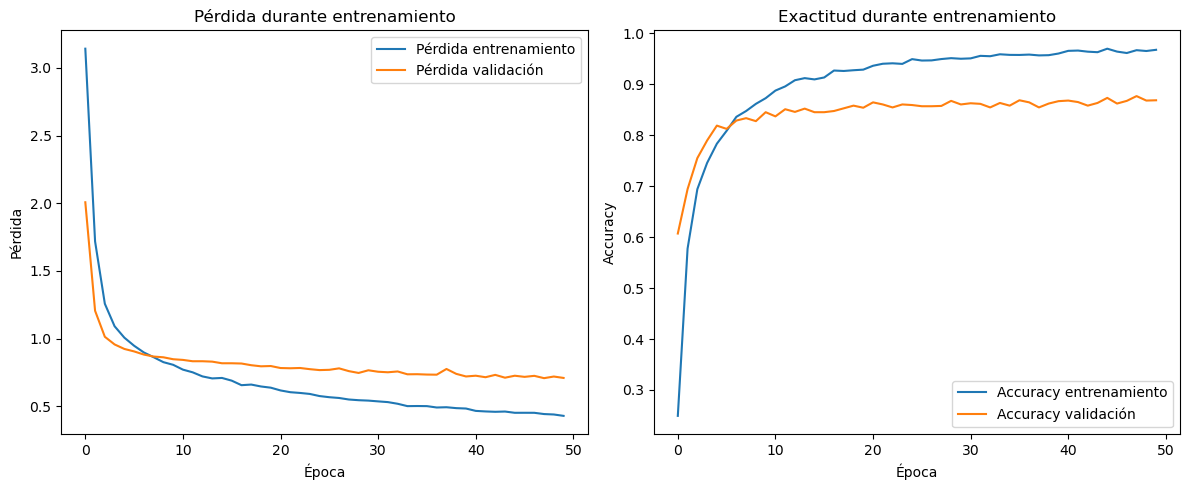

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# -------------------------------
# 1. Filtrar clases con frecuencia >= 150
# -------------------------------
frequencies = df['GRD -Código'].value_counts()
valid_classes = frequencies[frequencies >= 150].index
df = df[df['GRD -Código'].isin(valid_classes)].copy()

# -------------------------------
# 2. Prefiltrado y limpieza de variables de interés
# -------------------------------
variables_interes = [
    'Situacion al alta','Edad','Grupo Edad','Días estancia','Dx principal de egreso ','Cuidados intensivos',
    'Días de Unidad Cuidado Intensivo','Tipo de ingreso','Dx principal de egreso .1',
    'Código causa externa','Proc1','Proc2','Proc3','Dxr 1','Dxr 2','Dx Ppal 3 Caracteres',
    'Infección Quirurgica','Tipo servicio','Infecciones','Dx de ingreso','ServicioAlta',
    'Proc4','Sexo','Dxr 3','Causa externa','Aseguradora -Código-',
    'Aseguradora -Descripción-','Dxr 4','Causa Basica de muerte','Dxr 5','Codigo de ciudad',
    'Proc5','Dxr-6','Proc6','Dxr 7','Proc7','Dxr 8','Dxr 9','Proc8','Proc9','Proc16','Proc28'
]

# Subconjunto de datos
df_selected = df[variables_interes].copy()

# Limpieza de texto: pasar todo a mayúsculas para unificar categorías
df_selected = df_selected.apply(lambda col: col.apply(lambda x: x.upper() if isinstance(x, str) else x)
                                if col.dtype == 'object' else col)

# Normalizar nombres de categorías específicas
df_selected['Tipo de ingreso'] = df_selected['Tipo de ingreso'].str.replace('URGENCIAS', 'URGENCIA', regex=False)
df_selected['Tipo servicio'] = df_selected['Tipo servicio'].replace({
    'ATENCIÓN PRIORITARIA': 'URGENCIA ADULTOS',
    'URGENCIA - ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA ADULTO': 'URGENCIA ADULTOS',
    'URGENCIA ADULTOS.': 'URGENCIA ADULTOS',
    'U. ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA PEDIATRICAS': 'URGENCIA PEDÍATRICAS',
    'N0 APLICA': 'NO APLICA',
    'CIRUGIA': 'CIRUGÍA'
})

df_selected['Situacion al alta'] = df_selected['Situacion al alta'].replace({
    'MUERTO': 'FALLECIDO',
    'ALTA MEDICA': 'ALTA MÉDICA',
})

# -------------------------------
# 3. Separar variable objetivo y características
# -------------------------------
y = df['GRD -Código']
X = df_selected.copy()

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Pipelines de preprocesamiento
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Aplicar transformación
X_processed = preprocessor.fit_transform(X)

# Codificar la variable objetivo
y_encoded, y_categories = pd.factorize(y)
y_categorical = to_categorical(y_encoded)

# Dividir en entrenamiento, validación y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=np.argmax(y_train_full, axis=1)
)

# Construcción del modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación final
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\n Accuracy final en test: {accuracy:.4f}')

# 14. Graficar historia del entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.title('Exactitud durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# mostrar cuantos de las clases
class_counts = df['GRD -Código'].value_counts()
print(class_counts)
print(f'Número de clases: {len(class_counts)}')

GRD -Código
44173     732
114122    691
54123     631
44163     578
114123    433
14221     363
44162     354
114102    291
114131    286
174133    285
44172     264
81801     258
54122     252
114121    246
14263     242
54152     223
54153     208
44153     205
44181     203
44161     203
64181     199
174132    198
114103    192
104102    187
81701     183
64171     178
14222     177
71141     172
44171     172
51153     169
64172     167
81601     164
81201     162
64182     160
14262     159
74113     159
54193     158
61131     158
74103     157
14231     157
64183     150
214123    150
Name: count, dtype: int64
Número de clases: 42


En esta tercera versión del modelo se aplicó un umbral aún más estricto sobre la variable objetivo, filtrando los códigos GRD con menos de 150 registros, lo que redujo significativamente el número de clases a 42. Este ajuste permitió una mayor homogeneidad en la distribución de las clases y facilitó el entrenamiento del modelo, al disminuir el desbalance y la complejidad de la clasificación multiclase.

Se mantuvo la misma estructura de preprocesamiento y arquitectura del modelo: imputación, escalamiento, codificación one-hot y una red neuronal con dos capas ocultas (128 y 64 neuronas) con regularización L2 y Dropout, entrenada con categorical_crossentropy.

Como resultado, el modelo alcanzó un rendimiento notable: una precisión del 86.8% en el conjunto de prueba y una pérdida de solo 0.7087, lo cual representa una mejora considerable respecto a los modelos anteriores.

Este rendimiento mejorado es coherente con la reducción del número de clases y del nivel de desbalance, lo cual permite al modelo concentrar mejor su aprendizaje en patrones más representativos y consistentes. En síntesis, el filtrado por frecuencia mínima más estricta resultó en un modelo más preciso, confiable y eficiente para la tarea de clasificación de GRD.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.utils import class_weight

# 1. Cargar datos
ruta = r"C:\Users\Federico\Downloads\dabe de datos.xlsx"
df = pd.read_excel(ruta)

# 2. Filtrar GRD -Código con más de 70 registros
grd_counts = df['GRD -Código'].value_counts()
grd_validos = grd_counts[grd_counts > 70].index
df_filtrado = df[df['GRD -Código'].isin(grd_validos)].copy()

# 3. Definir variables de interés
variables_interes = [
    'Edad','Grupo Edad','Días estancia','Dx principal de egreso ','Cuidados intensivos','Días de Unidad Cuidado Intensivo',
    'Tipo de ingreso','Dx principal de egreso .1','Código causa externa','Proc1','Proc2','Proc3','Dxr 1','Dxr 2','Dx Ppal 3 Caracteres',
    'Infección Quirurgica','Tipo servicio','Infecciones','Dx de ingreso','ServicioAlta','Proc4','Sexo','Dxr 3','Causa externa',
    'Aseguradora -Código-','Proc5','Aseguradora -Descripción-','Dxr 4','Causa Basica de muerte','Dxr 5','Codigo de ciudad','Proc6','Dxr-6',
    'Proc7','Dxr 7','Proc8','Proc28','Dxr 8','Dxr 9','Proc9','Proc16','Situacion al alta'
]

X = df_filtrado[variables_interes].copy()
y = df_filtrado['GRD -Código']

# 4. Preprocesamiento de texto: pasar todo a mayúsculas
X = X.apply(lambda col: col.apply(lambda x: x.upper() if isinstance(x, str) else x) if col.dtype == 'object' else col)

# 5. Correcciones de etiquetas
X['Tipo de ingreso'] = X['Tipo de ingreso'].str.replace('URGENCIAS', 'URGENCIA')
X['Tipo servicio'] = X['Tipo servicio'].replace({
    'ATENCIÓN PRIORITARIA': 'URGENCIA ADULTOS',
    'URGENCIA - ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA ADULTO': 'URGENCIA ADULTOS',
    'URGENCIA ADULTOS.': 'URGENCIA ADULTOS',
    'U. ADULTOS': 'URGENCIA ADULTOS',
    'URGENCIA PEDIATRICAS': 'URGENCIA PEDÍATRICAS',
    'N0 APLICA': 'NO APLICA',
    'CIRUGIA': 'CIRUGÍA'
})
X['Situacion al alta'] = X['Situacion al alta'].replace({
    'MUERTO': 'FALLECIDO',
    'ALTA MEDICA': 'ALTA MÉDICA',
})

# 6. Codificar variable objetivo
y_encoded = LabelEncoder().fit_transform(y)

# 7. Codificación de variables categóricas
high_card_cols = [col for col in X.columns if X[col].nunique() > 20 and X[col].dtype == 'object']
low_card_cols = [col for col in X.columns if col not in high_card_cols and X[col].dtype == 'object']

# Label encode high-cardinality
X_label = X.copy()
for col in high_card_cols:
    X_label[col] = LabelEncoder().fit_transform(X_label[col].astype(str))

# One-hot encode low-cardinality
X_label = pd.get_dummies(X_label, columns=low_card_cols)

# 8. Escalar
X_scaled = StandardScaler().fit_transform(X_label)

# 9. Calcular class weights
class_weights_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = {i: w for i, w in enumerate(class_weights_array)}

# 10. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 11. Modelo base
xgb = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_encoded)), eval_metric='mlogloss', use_label_encoder=False)

# 12. GridSearch
param_grid = {
    'n_estimators': [200],
    'max_depth': [4],
    'learning_rate': [0.1],
    'subsample': [1],
    'colsample_bytree': [0.8]
}

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train, sample_weight=np.vectorize(class_weights_dict.get)(y_train))

# 13. Evaluación
best_model = grid.best_estimator_
print("Mejores parámetros encontrados:", grid.best_params_)

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nPrecisión final sobre test: {acc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Federico\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:11:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}

Precisión final sobre test: 0.6938

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54        17
           1       0.20      0.12      0.15        16
           2       0.36      0.26      0.30        19
           3       0.76      0.78      0.77        73
           4       0.49      0.54      0.51        35
           5       0.64      0.41      0.50        17
           6       0.82      0.87      0.84        31
           7       0.81      0.74      0.77        23
           8       0.64      0.76      0.70        21
           9       0.54      0.71      0.61        21
          10       0.55      0.66      0.60        32
          11       0.76      0.67      0.71        48
          12       0.56      0.67      0.61        21
          13       0.33      0.27      0.30    

En este modelo se utilizó XGBoost como clasificador para abordar el problema multiclase de predicción de códigos GRD. A diferencia de modelos anteriores basados en redes neuronales, aquí se integró una estrategia de optimización basada en GridSearchCV, evaluando distintos hiperparámetros (número de árboles, profundidad, tasa de aprendizaje, entre otros), y aplicando class weights balanceados para compensar el desequilibrio entre clases.

El conjunto de datos fue filtrado para incluir únicamente códigos GRD con más de 70 registros, resultando en 117 clases. Esto mantuvo la complejidad alta, con una distribución aún desequilibrada, pero suficiente para explorar un modelo robusto como XGBoost.

El modelo óptimo hallado incluyó 200 árboles, una profundidad máxima de 4, tasa de aprendizaje de 0.1 y muestreo completo (subsample=1). Con estos parámetros, se alcanzó una precisión final de 69.38% sobre el conjunto de prueba, un resultado competitivo considerando el número elevado de clases y la dificultad del problema.

El reporte de clasificación muestra un rendimiento variable entre clases: algunas con alta precisión y recall (por ejemplo, clase 15 con 96%), mientras que otras presentan bajo desempeño (clase 1 con 20% de precisión y 12% de recall). Esta variabilidad se asocia al tamaño y representatividad de cada clase. El promedio ponderado (weighted avg) de precisión, recall y F1 se mantiene en torno a 0.69, evidenciando una consistencia global aceptable.

### CONCLUSIÓN
Al comparar los cuatro modelos, se observa una mejora progresiva en la precisión a medida que se reduce el número de clases mediante filtros por frecuencia mínima, pasando de 117 a 42 clases. El modelo basado en XGBoost, aunque trabajó con el conjunto más amplio, presentó el menor rendimiento, lo que evidencia las limitaciones del algoritmo frente al desbalance extremo. Las redes neuronales ofrecieron mejores resultados, destacando especialmente los modelos filtrados con 100 y 150 registros. Sin embargo, aunque el modelo con 150 registros alcanzó la mayor precisión, sacrificó una porción considerable de la base de datos, afectando la representatividad diagnóstica. En cambio, el modelo con umbral de 100 logró un buen equilibrio entre rendimiento y cobertura, manteniendo una precisión alta con una representación diagnóstica más amplia, por lo que se selecciona como la mejor opción para continuar.

